In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#plot_n_b_psth.ipynb
#plot neural and behavior psth

import scipy.io as sio
import scipy.stats as sio_stat
import scipy.interpolate
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

%matplotlib notebook

In [3]:
%matplotlib notebook

In [4]:
# data_dir = '/Users/vivekathalye/Dropbox/Code/preeya_co_obstacle'
save_dir = r'D:\Dropbox\BMI_co_obs_paper\data\vivek\command_compare'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = r'D:\Dropbox\Data\preeya_co_obstacle'
data_path = os.path.join(data_dir, 'for_v_df.pkl')
print(os.path.exists(data_path))
d = pickle.load(open(data_path))

#UNPACK: 
decoder = d['decoder']
pre = d['pre']
num_targets = d['num_targets']
sample_period = d['sample_period']
target_hold_time = d['target_hold_time']
num_neurons = d['num_neurons']
target_color = d['target_color']
obs_big = d['obs_big']
obs_small = d['obs_small']
target_r_task = d['target_r_task'] #target_r_task = {0:1.7, 1:2.0}
cursor_r = d['cursor_r']
target_r_eff = d['target_r_eff']
target_pos = d['target_pos']
target_angle = np.arctan2(target_pos[:,1], target_pos[:,0])
target_dist = np.linalg.norm(target_pos, axis=1)
obs_pos = d['obs_pos']

tc_meta = d['tc_meta']
task_list = d['task_list']
num_tasks = len(task_list)
task2idx = d['task2idx']
idx2task = bmi_util.invert_dic(task2idx)
task2tc = d['task2tc']
tc_list = d['tc_list']
df = d['df']
df_label = d['df_label']

task_color = ['k', 'r']

True


#Need to: 
#bin commands 
#1)
#magnitude bins, percentiles: 0-25, 25-50, 50-75, 75-100
#2)
#angle bins: 8 bins starting centered at 0.  

In [5]:
list(df.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'task',
 'tc',
 'target',
 'trial',
 'bin',
 'trial_start',
 'trial_stop',
 'target_size',
 'obs_size']

In [8]:
df['bin_end'][0:56]

0     54.0
1     53.0
2     52.0
3     51.0
4     50.0
5     49.0
6     48.0
7     47.0
8     46.0
9     45.0
10    44.0
11    43.0
12    42.0
13    41.0
14    40.0
15    39.0
16    38.0
17    37.0
18    36.0
19    35.0
20    34.0
21    33.0
22    32.0
23    31.0
24    30.0
25    29.0
26    28.0
27    27.0
28    26.0
29    25.0
30    24.0
31    23.0
32    22.0
33    21.0
34    20.0
35    19.0
36    18.0
37    17.0
38    16.0
39    15.0
40    14.0
41    13.0
42    12.0
43    11.0
44    10.0
45     9.0
46     8.0
47     7.0
48     6.0
49     5.0
50     4.0
51     3.0
52     2.0
53     1.0
54     0.0
55    41.0
Name: bin_end, dtype: float64

In [75]:
bnd[-1]

54

In [97]:
#Useful for analysis:
#Add a time till end of trial: 

#Trial boundaries:
# trial_start = np.where((df['trial_start']==1))[0]
trial_start = np.where((df['bin']==-10.0))[0]
trial_stop = np.where((df['trial_stop']==1))[0]
trial_bound = np.vstack((trial_start,trial_stop)).T
num_trials = trial_bound.shape[0]

df['bin_end'] = 0
df['prog'] = 0

for bnd in trial_bound:
    bin_data = df['bin'][bnd[0]:bnd[1]+1]
    last_bin = bin_data.iloc[-1]
    bin_end = last_bin-bin_data
    prog = bin_data/last_bin
    #ASSIGN:
    df['bin_end'][bnd[0]:bnd[1]+1] = bin_end
    df['prog'][bnd[0]:bnd[1]+1] = prog

c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [98]:
print(df['bin'][0:56])
print(df['prog'][0:56])

0    -10.0
1     -9.0
2     -8.0
3     -7.0
4     -6.0
5     -5.0
6     -4.0
7     -3.0
8     -2.0
9     -1.0
10     0.0
11     1.0
12     2.0
13     3.0
14     4.0
15     5.0
16     6.0
17     7.0
18     8.0
19     9.0
20    10.0
21    11.0
22    12.0
23    13.0
24    14.0
25    15.0
26    16.0
27    17.0
28    18.0
29    19.0
30    20.0
31    21.0
32    22.0
33    23.0
34    24.0
35    25.0
36    26.0
37    27.0
38    28.0
39    29.0
40    30.0
41    31.0
42    32.0
43    33.0
44    34.0
45    35.0
46    36.0
47    37.0
48    38.0
49    39.0
50    40.0
51    41.0
52    42.0
53    43.0
54    44.0
55   -10.0
Name: bin, dtype: float64
0    -0.227273
1    -0.204545
2    -0.181818
3    -0.159091
4    -0.136364
5    -0.113636
6    -0.090909
7    -0.068182
8    -0.045455
9    -0.022727
10    0.000000
11    0.022727
12    0.045455
13    0.068182
14    0.090909
15    0.113636
16    0.136364
17    0.159091
18    0.181818
19    0.204545
20    0.227273
21    0.250000
22    0.272727
23    0.29545

In [9]:
#First: Polar coordinates: 

# 1) Convert stuff to polar, 2) center angles at target angle, 3) calculate distance to target
# 1) Convert stuff to polar
df['p_mag'], df['p_angle'] = bmi_b.cartesian2polar(df['kin_py'], df['kin_px'])
df['v_mag'], df['v_angle'] = bmi_b.cartesian2polar(df['kin_vy'], df['kin_vx'])
df['u_p_mag'], df['u_p_angle'] = bmi_b.cartesian2polar(df['u_py'], df['u_px'])
df['u_v_mag'], df['u_v_angle'] = bmi_b.cartesian2polar(df['u_vy'], df['u_vx'])
# 2) Center @ target angle: 
d_list = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
for d in d_list:
    data = df[d]
    zeros = np.zeros(data.shape)
    t_angle = target_angle[df['target'].astype(int)]
    df[d+'_ctr'] = bmi_b.center_angle(df[d], zeros, t_angle)
# 3) distance to target
error = df.loc[:, 'kin_px':'kin_py']-target_pos[df['target'].astype(int),:]
df['d2target'] = np.linalg.norm(error,ord=2,axis=1)
df['x_error'] = error.loc[:,'kin_px']
df['y_error'] = error.loc[:,'kin_py']

In [10]:
df['u_v_angle'].min()*180/np.pi

-179.97251025514896

In [11]:
df['u_v_angle'].max()*180/np.pi

179.99381945207733

In [10]:
list(df.columns)

#  'u_px',
#  'u_py',
#  'u_vx',
#  'u_vy',

#  'u_v_mag',
#  'u_v_angle',

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'task',
 'tc',
 'target',
 'trial',
 'bin',
 'trial_start',
 'trial_stop',
 'target_size',
 'obs_size',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 'u_v_mag',
 'u_v_angle',
 'p_angle_ctr',
 'v_angle_ctr',
 'u_p_angle_ctr',
 'u_v_angle_ctr',
 'd2target',
 'x_error',
 'y_error']

In [5]:
df.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,kin_vy,task,tc,target,trial,bin,trial_start,trial_stop,target_size,obs_size
0,2.0,1.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,...,1.004399,0.0,4377.0,0.0,12.0,-10.0,0.0,0.0,1.7,0.0
1,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,2.871518,0.0,4377.0,0.0,12.0,-9.0,0.0,0.0,1.7,0.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,2.696526,0.0,4377.0,0.0,12.0,-8.0,0.0,0.0,1.7,0.0
3,5.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,0.0,0.0,...,0.364251,0.0,4377.0,0.0,12.0,-7.0,0.0,0.0,1.7,0.0
4,4.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,...,1.091997,0.0,4377.0,0.0,12.0,-6.0,0.0,0.0,1.7,0.0


### BINS: 

In [12]:
#1) magnitude bins: 
num_mag_bins = 4
mag_bin_perc = np.array([0,25,50,75,100])
mag_data = df['u_v_mag']
#mag_data = df['u_v_mag'][df['bin']>=0] - we didn't do this, because we want to be able to bin all data, negative bins
mag_bin = np.percentile(mag_data, mag_bin_perc)
mag_bin_edges = np.vstack((mag_bin[0:-1], mag_bin[1:]))
mag_bin_c = mag_bin_edges.mean(axis=0)

In [13]:
print(mag_bin)
print(mag_bin_edges)
print(mag_bin_c)

[0.00880115 0.80946662 1.28016195 1.86169573 7.01433267]
[[0.00880115 0.80946662 1.28016195 1.86169573]
 [0.80946662 1.28016195 1.86169573 7.01433267]]
[0.40913388 1.04481428 1.57092884 4.4380142 ]


In [14]:
target0_angle = -3*(2*np.pi)/8
print(target0_angle*180/np.pi)

-135.0


In [15]:
#2) angle bins: 
num_angle_bins = 8

T0_angle = -3*(2*np.pi)/8
angle_bin_c = np.linspace(T0_angle, T0_angle+np.pi*2, num=num_angle_bins+1, endpoint=True)
# angle_bin_c[angle_bin_c > np.pi] = angle_bin_c[angle_bin_c > np.pi] - 2*np.pi #center at angle 0 instead of 180
angle_bin = angle_bin_c-np.pi*2/16.0
# angle_bin[angle_bin < -np.pi] = angle_bin[angle_bin < -np.pi] + 2*np.pi
angle_bin_edges = np.vstack((angle_bin[0:-1], angle_bin[1:]))

In [ ]:
#TODO: make the bin angles match the target directions

In [16]:
print(angle_bin_c*180/np.pi)
print(angle_bin*180/np.pi)
print(angle_bin_edges*180/np.pi)

[-135.  -90.  -45.    0.   45.   90.  135.  180.  225.]
[-157.5 -112.5  -67.5  -22.5   22.5   67.5  112.5  157.5  202.5]
[[-157.5 -112.5  -67.5  -22.5   22.5   67.5  112.5  157.5]
 [-112.5  -67.5  -22.5   22.5   67.5  112.5  157.5  202.5]]


In [17]:
#center angles for binning: 
angle_center_for_binning = (angle_bin[-1]+angle_bin[0])/2.0
print('angle_center:', angle_center_for_binning*180/np.pi)

angle_vars = ['p_angle', 'v_angle', 'u_p_angle', 'u_v_angle']
for d in angle_vars:
    df[d] = bmi_b.center_angle_v2(np.array(df[d]), angle_center_for_binning)
print('min centered angle:', np.min(df['u_v_angle'])*180/np.pi)
print('max centered angle:', np.max(df['u_v_angle'])*180/np.pi)

('angle_center:', 22.5)
('min centered angle:', -157.4975492637699)
('max centered angle:', 202.46708261619673)


In [18]:
#BIN DATA: 
bin_dic = {}
bin_dic[0] = mag_bin_edges
bin_dic[1] = angle_bin_edges

data2bin = np.array(df[['u_v_mag','u_v_angle']])
bin_r, hist_r = bmi_b.bin_vec_data(data2bin, bin_dic)
df['u_v_mag_bin']=bin_r[:,0]
df['u_v_angle_bin']=bin_r[:,1]

In [33]:
bin_r[:,0].max()

3.0

In [32]:
bin_r[:,1].max()

7.0

In [34]:
df['u_v_mag_bin']=bin_r[:,0]
df['u_v_angle_bin']=bin_r[:,1]

In [ ]:
#Plot bins and the vector: 

In [208]:
list(df.columns)

['n_0',
 'n_1',
 'n_2',
 'n_3',
 'n_4',
 'n_5',
 'n_6',
 'n_7',
 'n_8',
 'n_9',
 'n_10',
 'n_11',
 'n_12',
 'n_13',
 'n_14',
 'n_15',
 'n_16',
 'n_17',
 'n_18',
 'n_19',
 'n_20',
 'n_21',
 'n_22',
 'n_23',
 'n_24',
 'n_25',
 'n_26',
 'n_27',
 'n_28',
 'n_29',
 'n_30',
 'n_31',
 'n_32',
 'n_33',
 'n_34',
 'n_35',
 'n_36',
 'n_37',
 'n_38',
 'n_39',
 'n_40',
 'n_41',
 'n_42',
 'n_43',
 'u_px',
 'u_py',
 'u_vx',
 'u_vy',
 'kin_px',
 'kin_py',
 'kin_vx',
 'kin_vy',
 'task',
 'tc',
 'target',
 'trial',
 'bin',
 'trial_start',
 'trial_stop',
 'target_size',
 'obs_size',
 'p_mag',
 'p_angle',
 'v_mag',
 'v_angle',
 'u_p_mag',
 'u_p_angle',
 'u_v_mag',
 'u_v_angle',
 'p_angle_ctr',
 'v_angle_ctr',
 'u_p_angle_ctr',
 'u_v_angle_ctr',
 'd2target',
 'x_error',
 'y_error',
 'bin_end']

<IPython.core.display.Javascript object>


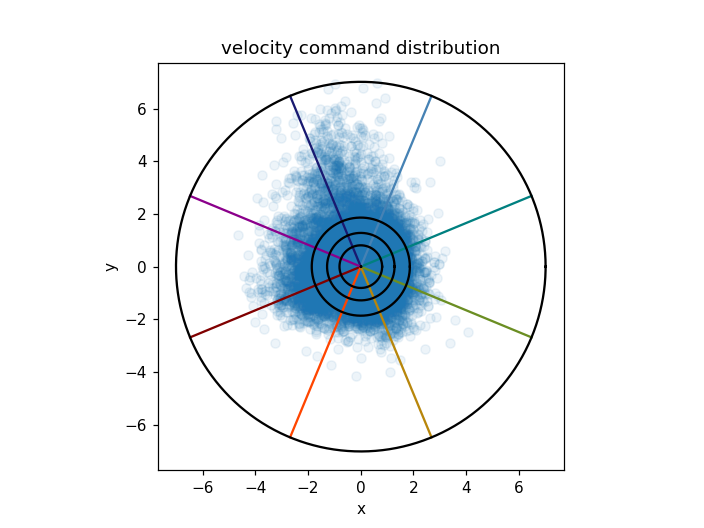

Text(0.5,1,'velocity command distribution')

In [19]:
i = 10
plt.figure()
plt.scatter(df['u_vx'], df['u_vy'],alpha=0.08)

for i,b in enumerate(angle_bin_edges.T):
    x1 = np.cos(b[0])*mag_bin[-1]
    y1 = np.sin(b[0])*mag_bin[-1]
    plt.plot([0, x1], [0, y1], color=target_color[i])
for b in mag_bin:
    theta = np.linspace(0,2*np.pi,1000)
    plt.plot(b*np.cos(theta), b*np.sin(theta), 'k')
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')
plt.title('velocity command distribution')

In [59]:
angle_bin_c

array([-2.35619449, -1.57079633, -0.78539816,  0.        ,  0.78539816,
        1.57079633,  2.35619449,  3.14159265,  3.92699082])

In [84]:
def plot_command_bin():
    for i,b in enumerate(angle_bin_edges.T):
        x1 = np.cos(b[0])*mag_bin[-1]
        y1 = np.sin(b[0])*mag_bin[-1]
#         plt.plot([0, x1], [0, y1], color=target_color[i])
        plt.plot([0, x1], [0, y1], '--', color=np.ones(3)*0.8,zorder=0)#'k')
    for i,a in enumerate(angle_bin_c[:-1]): 
        x1 = np.cos(a)*mag_bin[-1]
        y1 = np.sin(a)*mag_bin[-1]        
        plt.plot([0, x1], [0, y1], color=target_color[i], linewidth=3,zorder=0)
    
    for b in mag_bin:
        theta = np.linspace(0,2*np.pi,1000)
        plt.plot(b*np.cos(theta), b*np.sin(theta), 'k',zorder=0)
    plt.axis('square')
    plt.xlabel('x')
    plt.ylabel('y')

<IPython.core.display.Javascript object>


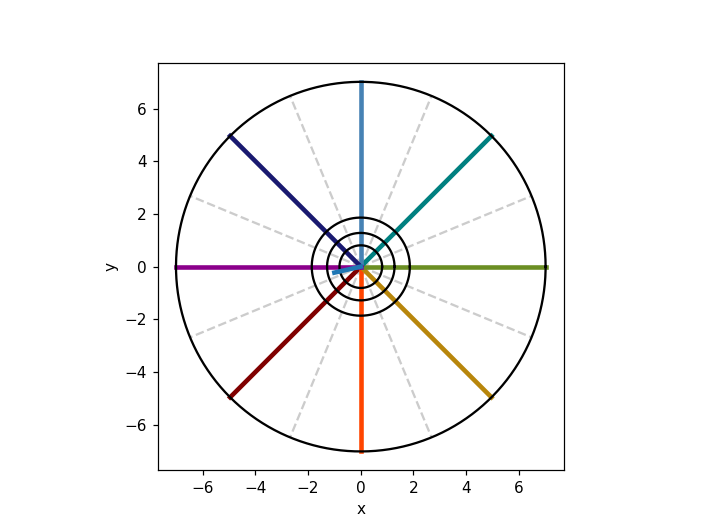

[1. 7.]


In [85]:
#Plot an individual command to confirm the binning!  : 
i = 13500
x = df['u_vx'][i]
y = df['u_vy'][i]

plt.figure()
plot_command_bin()
plt.plot([0,x], [0,y],linewidth=3)
print(bin_r[i])

In [40]:
target_color

['maroon',
 'orangered',
 'darkgoldenrod',
 'olivedrab',
 'teal',
 'steelblue',
 'midnightblue',
 'darkmagenta']

<IPython.core.display.Javascript object>


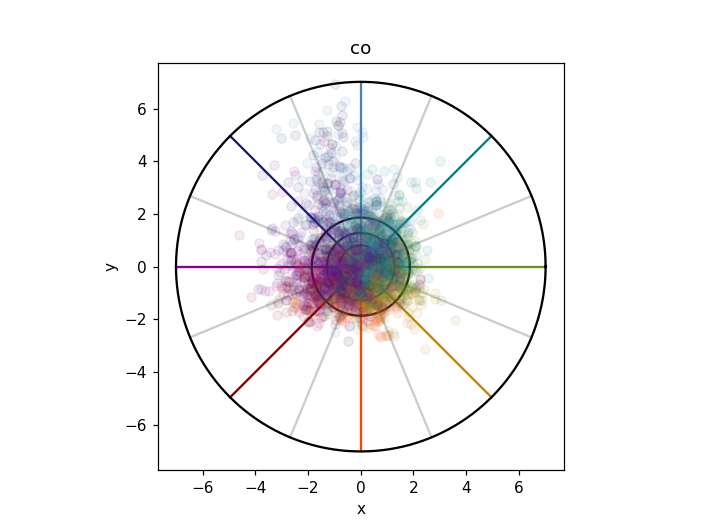

<IPython.core.display.Javascript object>


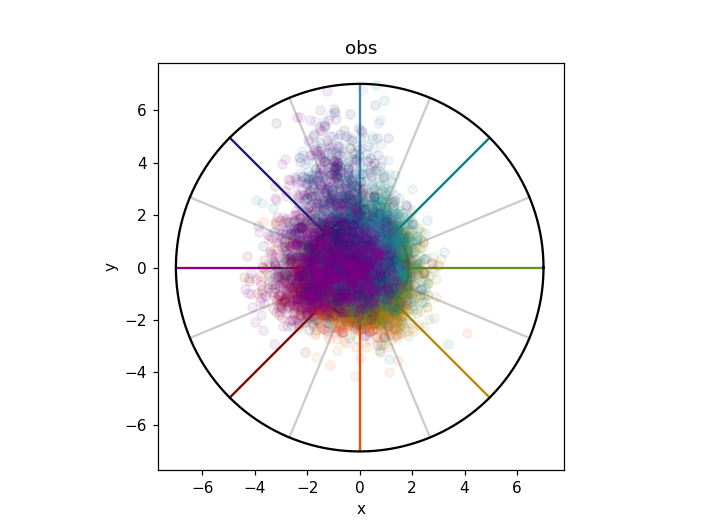

Text(0,0.5,'y')

In [67]:
i = 10
for task in range(num_tasks):
    plt.figure()
    plt.title(task_list[task])    
    plot_command_bin()
    for target in range(num_targets):
            task_sel = (df['task'] == task)
            target_sel = (df['target'] == target)
            sel = task_sel & target_sel
            
            x = df['u_vx'][sel]
            y = df['u_vy'][sel]
            plt.scatter(x, y,alpha=0.08,color=target_color[target],zorder=1000)

plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

<IPython.core.display.Javascript object>


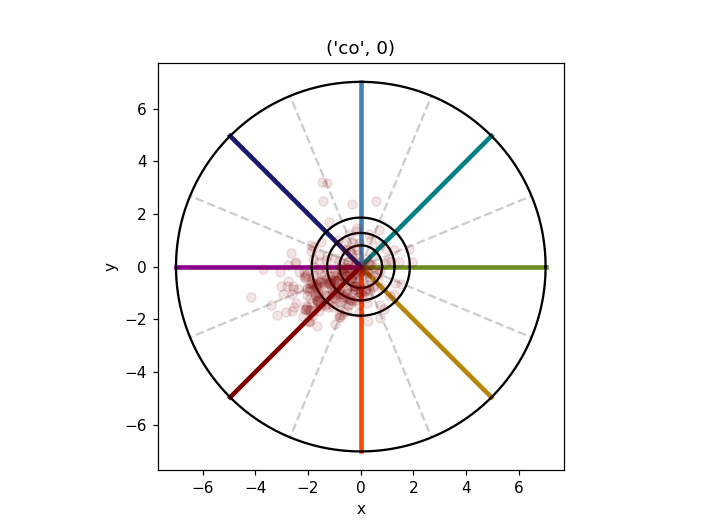

<IPython.core.display.Javascript object>


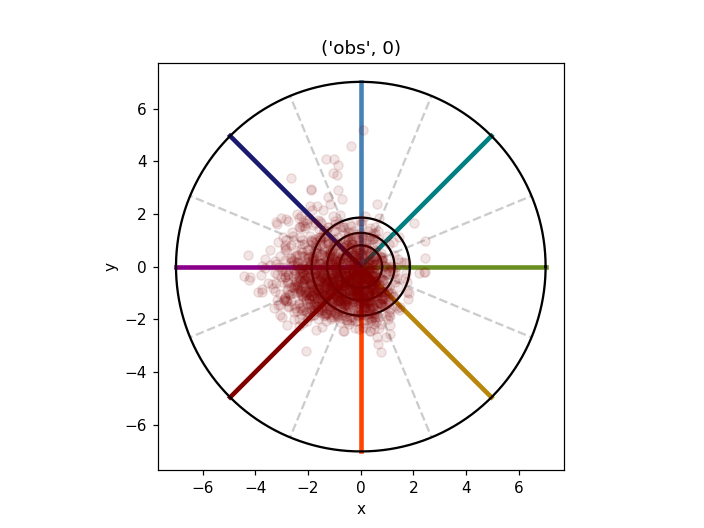

<IPython.core.display.Javascript object>


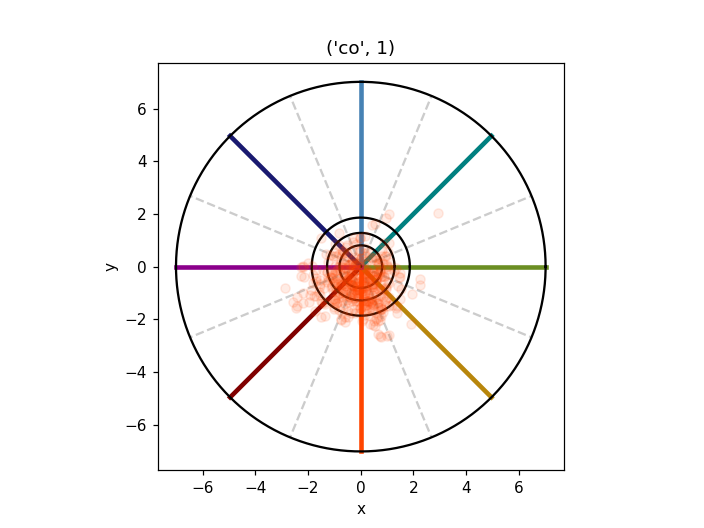

<IPython.core.display.Javascript object>


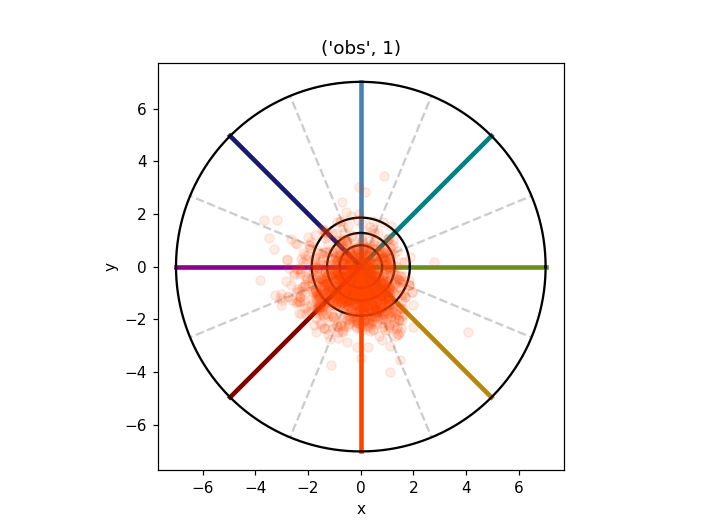

<IPython.core.display.Javascript object>


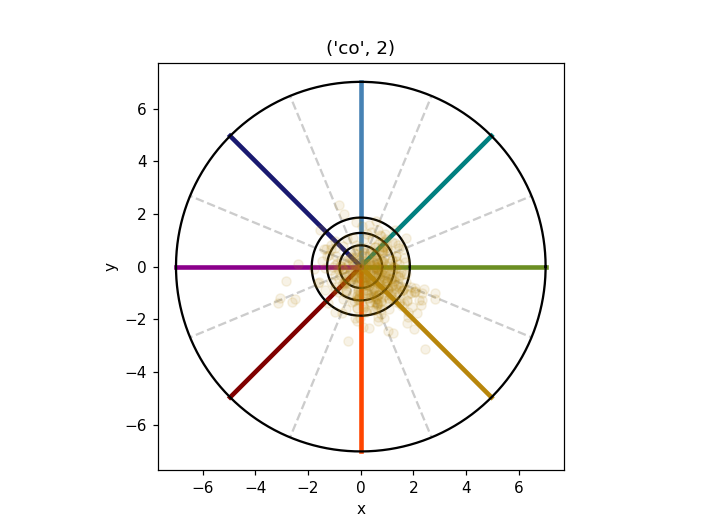

<IPython.core.display.Javascript object>


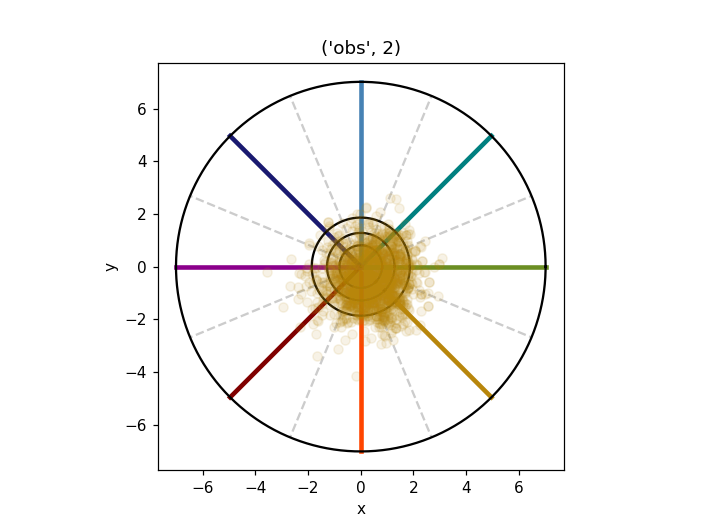

<IPython.core.display.Javascript object>


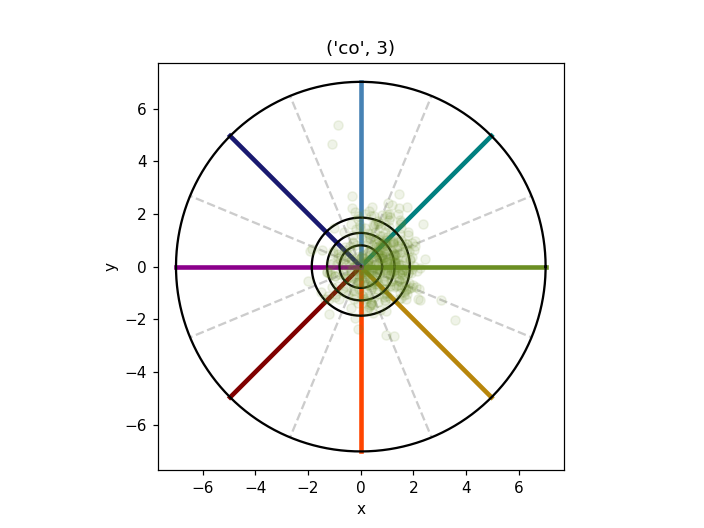

<IPython.core.display.Javascript object>


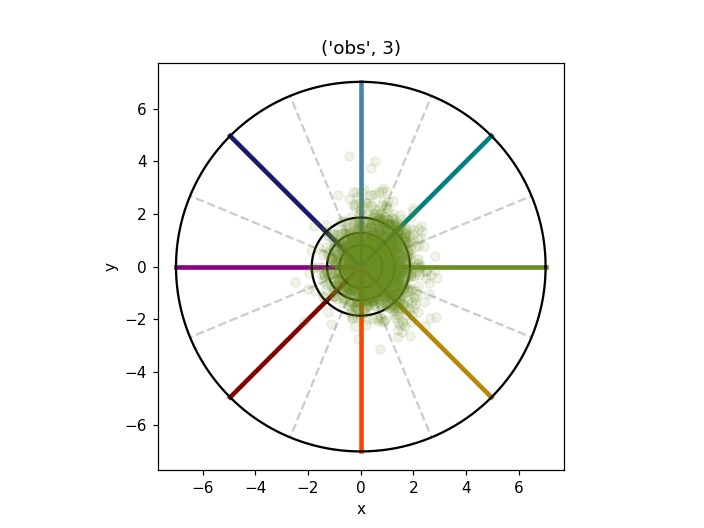

<IPython.core.display.Javascript object>


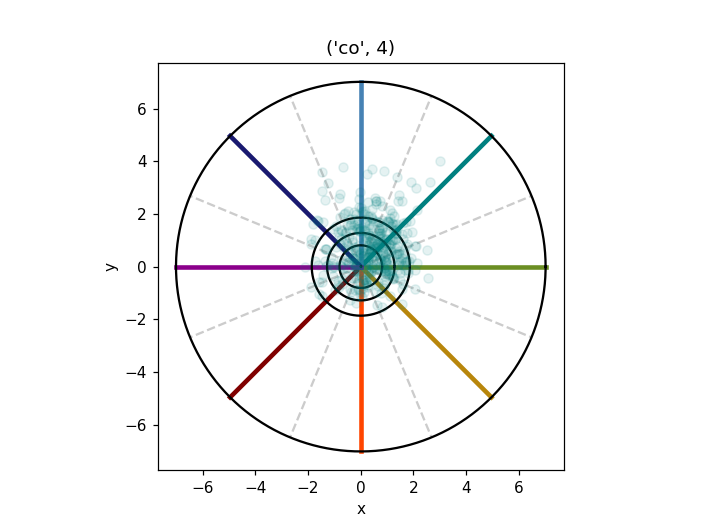

<IPython.core.display.Javascript object>


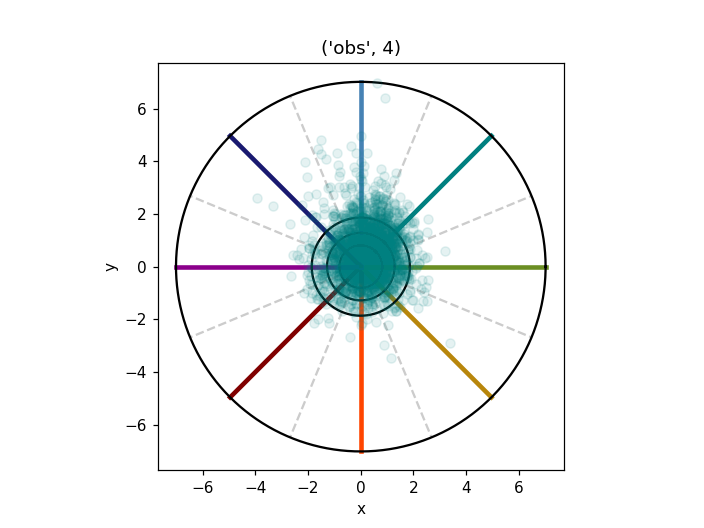

<IPython.core.display.Javascript object>


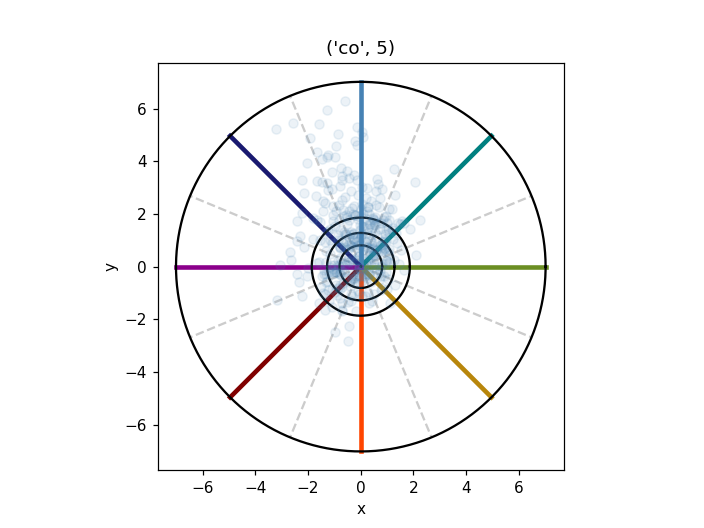

<IPython.core.display.Javascript object>


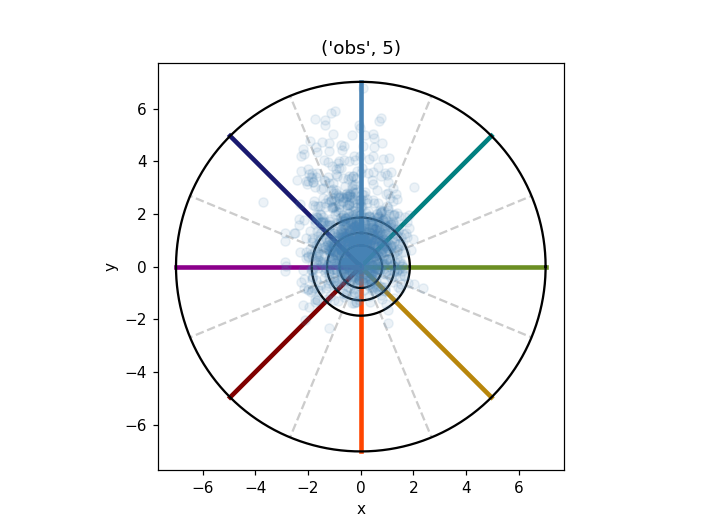

<IPython.core.display.Javascript object>


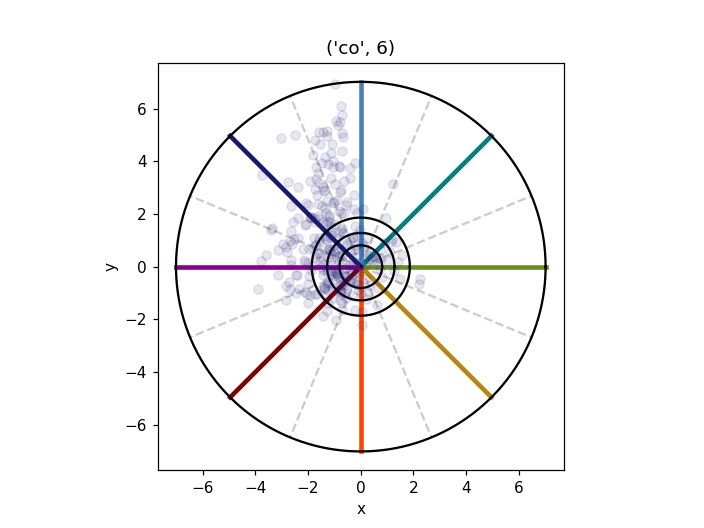

<IPython.core.display.Javascript object>


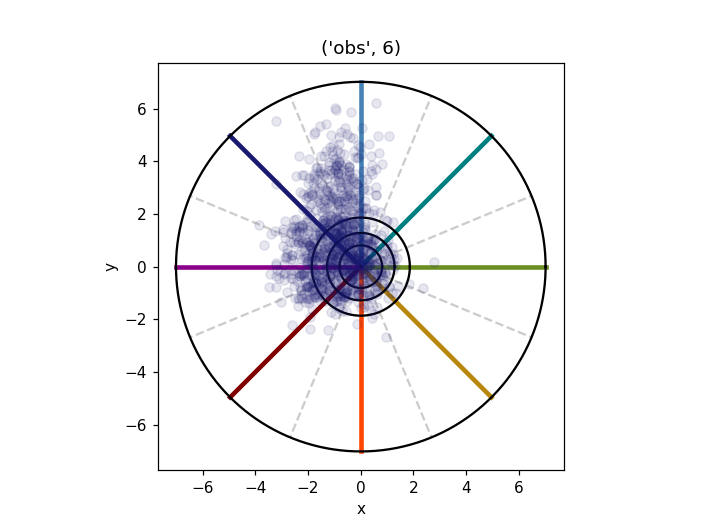

<IPython.core.display.Javascript object>


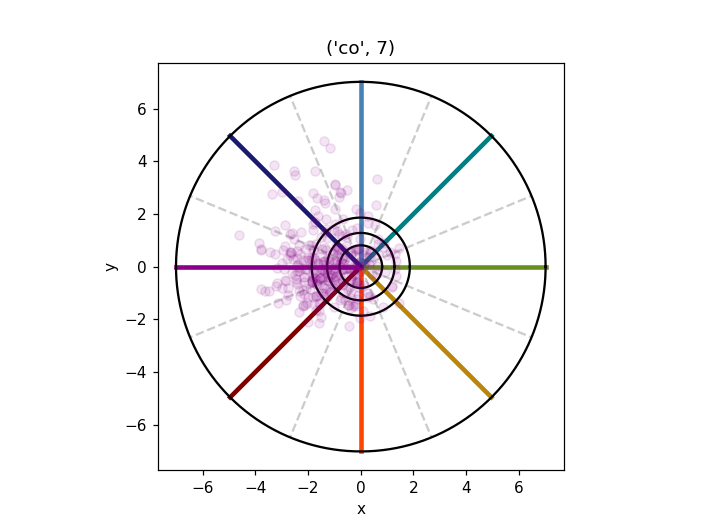

<IPython.core.display.Javascript object>


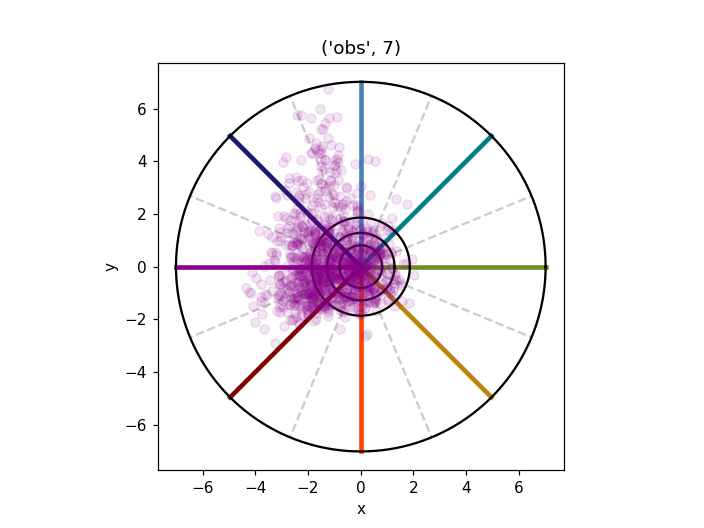

Text(0,0.5,'y')

In [86]:
for target in range(num_targets): #[0]
    for task in range(num_tasks):
        plt.figure()
        plt.title((task_list[task], target))    
        plot_command_bin()        
        
        task_sel = (df['task'] == task)
        target_sel = (df['target'] == target)
        sel = task_sel & target_sel

        x = df['u_vx'][sel]
        y = df['u_vy'][sel]
        plt.scatter(x, y,alpha=0.1,color=target_color[target])

plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

In [87]:
np.where(df.columns=='prog')

(array([79], dtype=int64),)

In [112]:
phases

NameError: name 'phases' is not defined

In [123]:
#early middle late scatter plot
num_phases = 3
phases = np.linspace(0,1,num_phases+1)
trial_phase = np.array([phases[0:-1],phases[1:]])
# trial_phase = np.array([[0, 0.2, 0.6], [0.2, 0.6, 1]])
# trial_phase = np.array([[0, 0.33, 0.66], [0.33, 0.66, 1]])
trial_phase

array([[0.        , 0.33333333, 0.66666667],
       [0.33333333, 0.66666667, 1.        ]])

In [129]:
np.ravel_multi_index((0,1), (2,3))

1

<IPython.core.display.Javascript object>


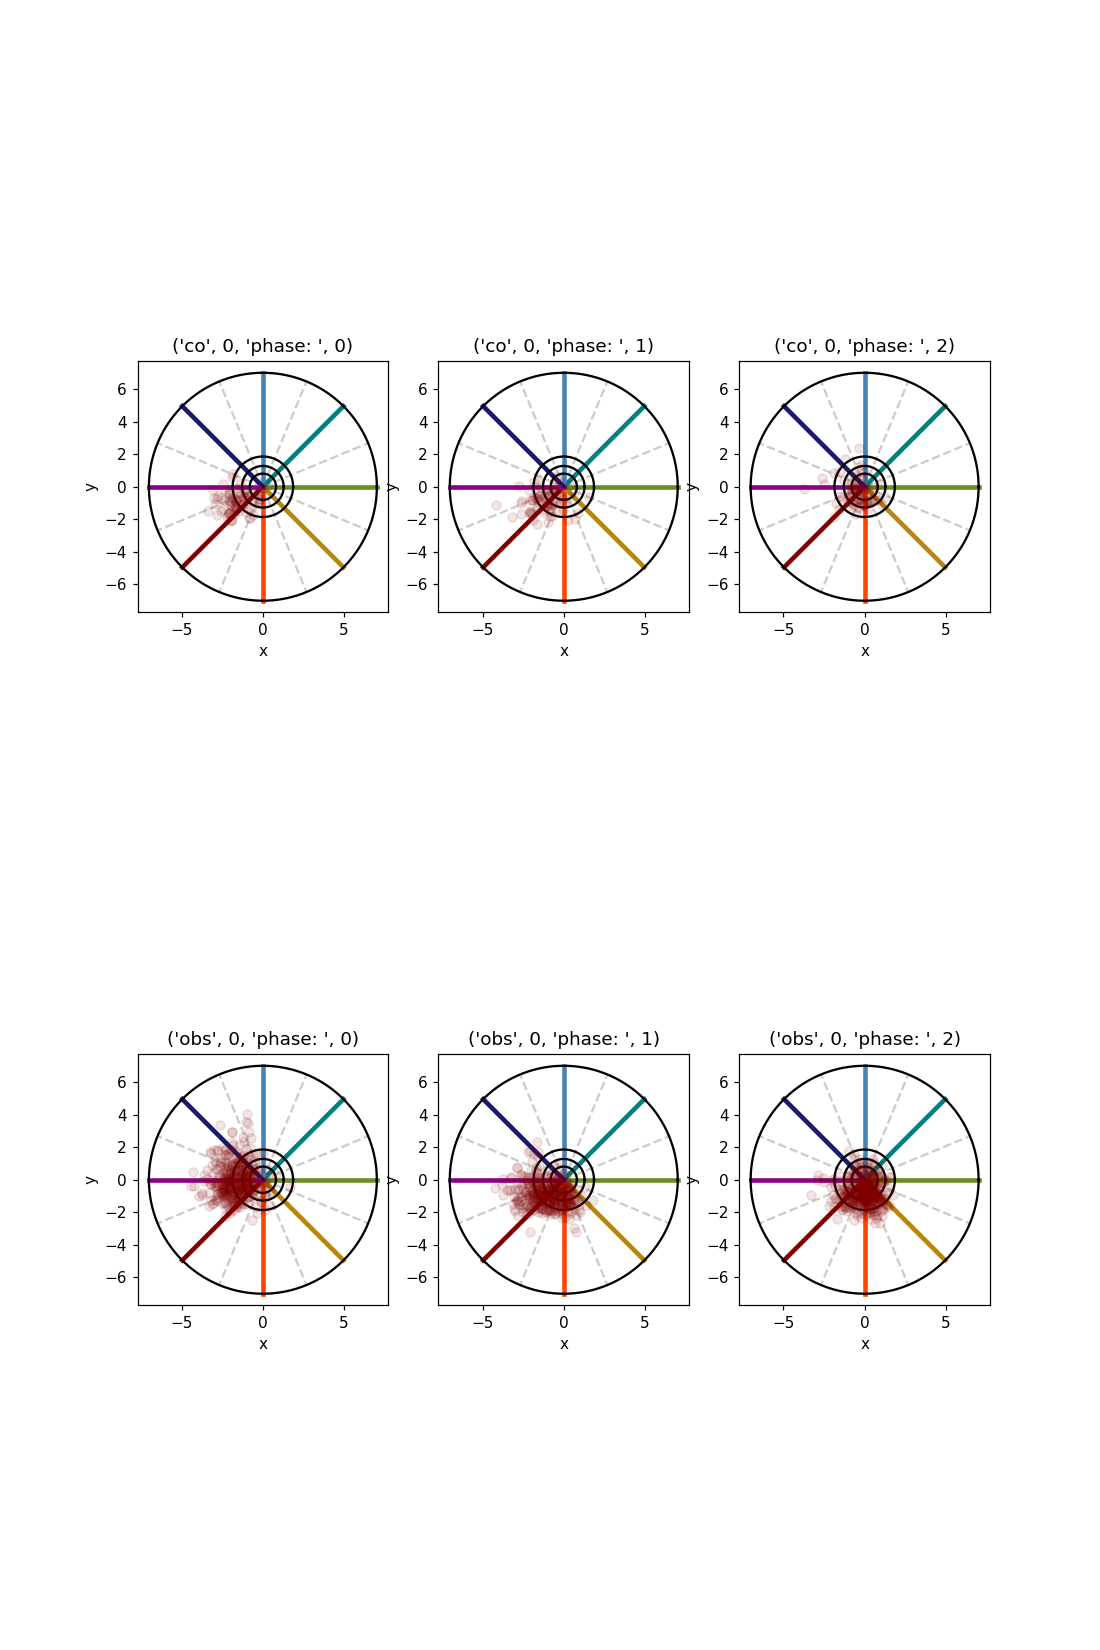

Text(0,0.5,'y')

In [133]:
phase_color = ['g', 'b', 'r'] #maroon
for target in [0]: #range(num_targets): #[0]
    plt.figure(figsize=(10,15))
    for task in range(num_tasks):
        for phase in range(num_phases):
            plt.subplot(2,3,np.ravel_multi_index((task,phase), (2,3))+1)
            plot_command_bin() 
            plt.title((task_list[task], target, 'phase: ', phase))
            
                 
            task_sel = (df['task'] == task)
            target_sel = (df['target'] == target)
            phase_sel = (df['prog'] >= trial_phase[0,phase]) & (df['prog'] <= trial_phase[1,phase])
            sel = task_sel & target_sel & phase_sel

            x = df['u_vx'][sel]
            y = df['u_vy'][sel]
            plt.scatter(x, y,alpha=0.1,color=target_color[target])
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

<IPython.core.display.Javascript object>


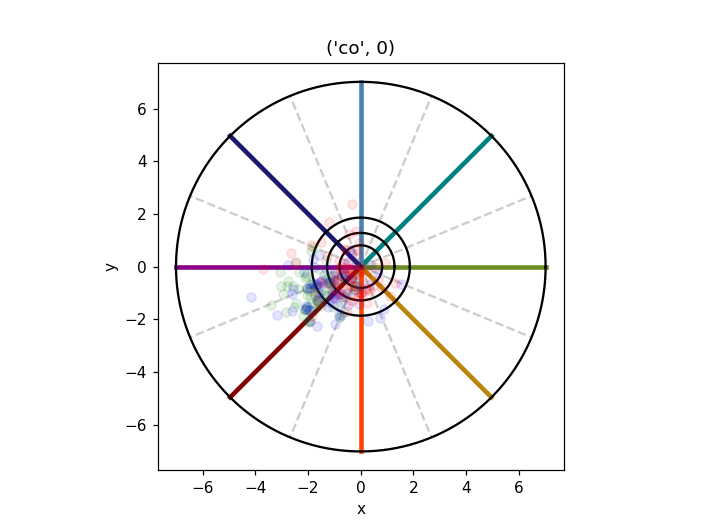

<IPython.core.display.Javascript object>


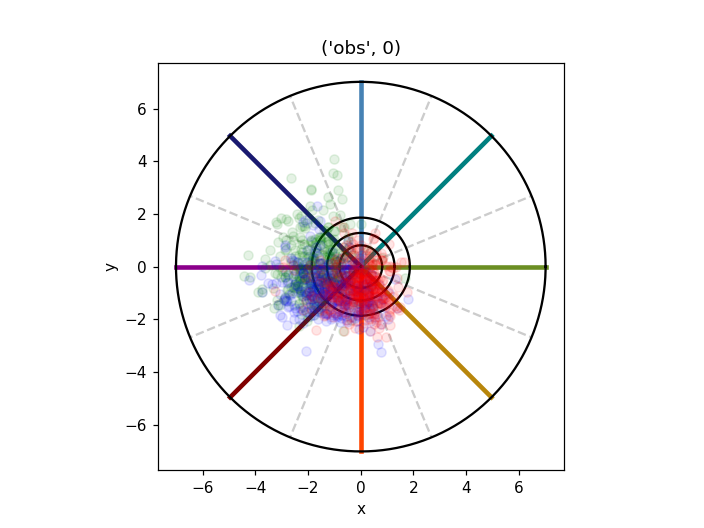

Text(0,0.5,'y')

In [125]:
phase_color = ['g', 'b', 'r'] #maroon
for target in [0]: #range(num_targets): #[0]
#     plt.subplot(2,3,)
    for task in range(num_tasks):
        plt.figure()
        plot_command_bin()   
        plt.title((task_list[task], target))    
        for phase in range(num_phases):
#             plt.title((task_list[task], target, 'phase: ', phase))    
                 
            task_sel = (df['task'] == task)
            target_sel = (df['target'] == target)
            phase_sel = (df['prog'] >= trial_phase[0,phase]) & (df['prog'] <= trial_phase[1,phase])
            sel = task_sel & target_sel & phase_sel

            x = df['u_vx'][sel]
            y = df['u_vy'][sel]
            plt.scatter(x, y,alpha=0.1,color=phase_color[phase])
# phase_color[phase])#target_color[target])
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

### ANALYSIS

In [236]:
#NOTE: This takes some time...
min_trials = 5
win = [-5, 5]
num_win = win[1]-win[0]+1
num_var = len(list(df.columns))
psth_var = ['u_vx', 'u_vy']

task_target_bin_dic=bmi_b.calc_command_trials_dic_da(df, win, num_var, num_tasks, num_targets, num_mag_bins, num_angle_bins)
bmi_b.calc_command_psth(task_target_bin_dic, psth_var, min_trials, num_tasks, num_targets, num_mag_bins, num_angle_bins)
da_diff, d_accum = bmi_b.calc_command_psth_diff(task_target_bin_dic, min_trials, num_targets, num_mag_bins, num_angle_bins)

(0, 0, 0, 0, 8)
(0, 0, 0, 1, 3)
(0, 0, 0, 2, 2)
(0, 0, 0, 3, 3)
(0, 0, 0, 4, 0)
(0, 0, 0, 5, 1)
(0, 0, 0, 6, 2)
(0, 0, 0, 7, 5)
(0, 0, 1, 0, 10)
(0, 0, 1, 1, 7)
(0, 0, 1, 2, 2)
(0, 0, 1, 3, 1)
(0, 0, 1, 4, 0)
(0, 0, 1, 5, 1)
(0, 0, 1, 6, 2)
(0, 0, 1, 7, 3)
(0, 0, 2, 0, 19)
(0, 0, 2, 1, 5)
(0, 0, 2, 2, 2)
(0, 0, 2, 3, 0)
(0, 0, 2, 4, 0)
(0, 0, 2, 5, 2)
(0, 0, 2, 6, 0)
(0, 0, 2, 7, 11)
(0, 0, 3, 0, 29)
(0, 0, 3, 1, 3)
(0, 0, 3, 2, 0)
(0, 0, 3, 3, 0)
(0, 0, 3, 4, 0)
(0, 0, 3, 5, 1)
(0, 0, 3, 6, 1)
(0, 0, 3, 7, 17)
(0, 1, 0, 0, 14)
(0, 1, 0, 1, 14)
(0, 1, 0, 2, 19)
(0, 1, 0, 3, 8)
(0, 1, 0, 4, 4)
(0, 1, 0, 5, 8)
(0, 1, 0, 6, 8)
(0, 1, 0, 7, 5)
(0, 1, 1, 0, 18)
(0, 1, 1, 1, 23)
(0, 1, 1, 2, 14)
(0, 1, 1, 3, 4)
(0, 1, 1, 4, 1)
(0, 1, 1, 5, 3)
(0, 1, 1, 6, 3)
(0, 1, 1, 7, 8)
(0, 1, 2, 0, 9)
(0, 1, 2, 1, 31)
(0, 1, 2, 2, 17)
(0, 1, 2, 3, 1)
(0, 1, 2, 4, 0)
(0, 1, 2, 5, 1)
(0, 1, 2, 6, 0)
(0, 1, 2, 7, 3)
(0, 1, 3, 0, 11)
(0, 1, 3, 1, 17)
(0, 1, 3, 2, 8)
(0, 1, 3, 3, 0)
(0, 1, 3, 4, 0)
(0, 1, 3,

(1, 7, 2, 7, 55)
(1, 7, 3, 0, 96)
(1, 7, 3, 1, 1)
(1, 7, 3, 2, 0)
(1, 7, 3, 3, 1)
(1, 7, 3, 4, 0)
(1, 7, 3, 5, 40)
(1, 7, 3, 6, 72)
(1, 7, 3, 7, 139)


### SHUFFLE data to compare

In [255]:
#SHUFFLE all the behavior var: 
S_df = copy.deepcopy(df)
shuffle_var = ['u_px', 'u_py', 'u_vx', 'u_vy', 'kin_px', 'kin_py', 'kin_vx', 'kin_vy', 
               'p_mag', 'p_angle', 'v_mag', 'v_angle', 'u_p_mag', 'u_p_angle', 'u_v_mag', 'u_v_angle',
              'p_angle_ctr', 'v_angle_ctr', 'u_p_angle_ctr', 'u_v_angle_ctr', 'u_v_mag_bin', 'u_v_angle_bin']
S_data = np.array(S_df.loc[:, shuffle_var])
np.random.shuffle(S_data)
S_df.loc[:,shuffle_var] = S_data

In [256]:
df.loc[0:10, ['u_v_mag_bin', 'u_v_angle_bin']]

,u_v_mag_bin,u_v_angle_bin
0,1.0,5.0
1,3.0,5.0
2,2.0,4.0
3,1.0,1.0
4,1.0,5.0
5,2.0,1.0
6,2.0,1.0
7,2.0,1.0
8,1.0,0.0
9,1.0,2.0


In [257]:
S_df.loc[0:10, ['u_v_mag_bin', 'u_v_angle_bin']]

,u_v_mag_bin,u_v_angle_bin
0,0.0,4.0
1,0.0,7.0
2,1.0,6.0
3,1.0,6.0
4,3.0,4.0
5,2.0,6.0
6,3.0,0.0
7,3.0,1.0
8,3.0,1.0
9,3.0,1.0


In [259]:
S_df = df_s
S_task_target_bin_dic=bmi_b.calc_command_trials_dic_da(df_s, win, num_var, num_tasks, num_targets, num_mag_bins, num_angle_bins)
bmi_b.calc_command_psth(S_task_target_bin_dic, psth_var, min_trials, num_tasks, num_targets, num_mag_bins, num_angle_bins)
S_da_diff, S_d_accum = bmi_b.calc_command_psth_diff(S_task_target_bin_dic, min_trials, num_targets, num_mag_bins, num_angle_bins)

(0, 0, 0, 0, 3)
(0, 0, 0, 1, 3)
(0, 0, 0, 2, 10)
(0, 0, 0, 3, 3)
(0, 0, 0, 4, 6)
(0, 0, 0, 5, 5)
(0, 0, 0, 6, 7)
(0, 0, 0, 7, 7)
(0, 0, 1, 0, 4)
(0, 0, 1, 1, 4)
(0, 0, 1, 2, 5)
(0, 0, 1, 3, 2)
(0, 0, 1, 4, 4)
(0, 0, 1, 5, 5)
(0, 0, 1, 6, 4)
(0, 0, 1, 7, 3)
(0, 0, 2, 0, 5)
(0, 0, 2, 1, 4)
(0, 0, 2, 2, 8)
(0, 0, 2, 3, 5)
(0, 0, 2, 4, 1)
(0, 0, 2, 5, 4)
(0, 0, 2, 6, 4)
(0, 0, 2, 7, 2)
(0, 0, 3, 0, 4)
(0, 0, 3, 1, 1)
(0, 0, 3, 2, 3)
(0, 0, 3, 3, 2)
(0, 0, 3, 4, 2)
(0, 0, 3, 5, 7)
(0, 0, 3, 6, 4)
(0, 0, 3, 7, 9)
(0, 1, 0, 0, 11)
(0, 1, 0, 1, 12)
(0, 1, 0, 2, 12)
(0, 1, 0, 3, 6)
(0, 1, 0, 4, 10)
(0, 1, 0, 5, 4)
(0, 1, 0, 6, 3)
(0, 1, 0, 7, 8)
(0, 1, 1, 0, 8)
(0, 1, 1, 1, 9)
(0, 1, 1, 2, 6)
(0, 1, 1, 3, 8)
(0, 1, 1, 4, 12)
(0, 1, 1, 5, 7)
(0, 1, 1, 6, 7)
(0, 1, 1, 7, 6)
(0, 1, 2, 0, 13)
(0, 1, 2, 1, 10)
(0, 1, 2, 2, 7)
(0, 1, 2, 3, 7)
(0, 1, 2, 4, 8)
(0, 1, 2, 5, 6)
(0, 1, 2, 6, 6)
(0, 1, 2, 7, 8)
(0, 1, 3, 0, 9)
(0, 1, 3, 1, 7)
(0, 1, 3, 2, 3)
(0, 1, 3, 3, 2)
(0, 1, 3, 4, 5)
(0, 1, 3, 5, 12)

(1, 7, 2, 2, 15)
(1, 7, 2, 3, 14)
(1, 7, 2, 4, 26)
(1, 7, 2, 5, 13)
(1, 7, 2, 6, 11)
(1, 7, 2, 7, 22)
(1, 7, 3, 0, 26)
(1, 7, 3, 1, 5)
(1, 7, 3, 2, 12)
(1, 7, 3, 3, 13)
(1, 7, 3, 4, 19)
(1, 7, 3, 5, 39)
(1, 7, 3, 6, 18)
(1, 7, 3, 7, 26)


### PLOT real vs shuffle: 

In [299]:
#make a fixed set of bins: 
diff_bins = np.linspace(0,10,40)
diff_bins_e = np.array([diff_bins[0:-1], diff_bins[1:]])

In [302]:
num_win

11

<IPython.core.display.Javascript object>


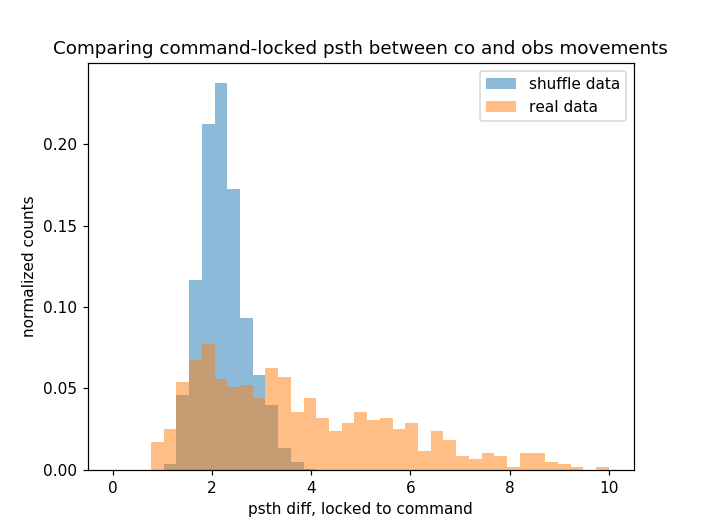

In [306]:
save_bool  = True
ext_list = ['.png', '.eps']

d_weights = np.ones_like(d_accum)/len(d_accum)
S_d_weights = np.ones_like(S_d_accum)/len(S_d_accum)


plt.figure()
plt.hist(S_d_accum, diff_bins, weights=S_d_weights, alpha=0.5, label='shuffle data')
plt.hist(d_accum, diff_bins, weights=d_weights, alpha=0.5, label='real data')

plt.legend()
plt.xlabel('psth diff, locked to command')
plt.ylabel('normalized counts')
plt.title('Comparing command-locked psth between co and obs movements')

if save_bool:
    for ext in ext_list:
        save_path = os.path.join(save_dir, 'command_psth_diff_across_task'+'_win'+str(num_win)+ext)
        plt.savefig(save_path)